In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import seaborn as sns
#Configure Defaults
import warnings
warnings.filterwarnings('ignore')
import missingno as msno
from tqdm import tqdm_notebook

plt.rcParams['font.family']='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결

In [2]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# 1. 사이킷런을 이용한 토픽 모델링
### 파이썬 텍스트 마이닝 완벽 가이드
### https://github.com/wikibook/textmining/blob/main/Ch%2007.%20%ED%86%A0%ED%94%BD%EB%AA%A8%EB%8D%B8%EB%A7%81.ipynb

In [3]:
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space', 
              'comp.sys.ibm.pc.hardware', 'sci.crypt']

#학습 데이터셋을 가져옴
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)

print('#Train set size:', len(newsgroups_train.data))
print('#Selected categories:', newsgroups_train.target_names)

#Train set size: 3219
#Selected categories: ['alt.atheism', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.crypt', 'sci.space', 'talk.religion.misc']


In [4]:
len(newsgroups_train.data)
type(newsgroups_train.data) # 하나의 ist안에 모든 doc가 'text ~~~'로 구분되어 있는 자료
newsgroups_train.data

3219

list

['From: livesey@solntze.wpd.sgi.com (Jon Livesey)\nSubject: Re: Moraltiy? (was Re: <Political Atheists?)\nOrganization: sgi\nLines: 63\nNNTP-Posting-Host: solntze.wpd.sgi.com\n\nIn article <1ql8ekINN635@gap.caltech.edu>, keith@cco.caltech.edu (Keith Allan Schneider) writes:\n|> livesey@solntze.wpd.sgi.com (Jon Livesey) writes:\n|> \n|> >>>>What if I act morally for no particular reason?  Then am I moral?  What\n|> >>>>if morality is instinctive, as in most animals?\n|> >>>\n|> >>>Saying that morality is instinctive in animals is an attempt to \n|> >>>assume your conclusion.\n|> >>\n|> >>Which conclusion?\n|> >\n|> >You conclusion - correct me if I err - that the behaviour which is\n|> >instinctive in animals is a "natural" moral system.\n|> \n|> See, we are disagreeing on the definition of moral here.  Earlier, you said\n|> that it must be a conscious act.  By your definition, no instinctive\n|> behavior pattern could be an act of morality.  You are trying to apply\n|> human terms to n

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(
    token_pattern='[^가-힣a-zA-Z\s]{3,}',# 모든 영숫자(alphanumeric character)가 3회이상 반복되는 패턴, 이것은 클래스 [a-zA-Z0-9_]와 동등합니다. 
    stop_words='english', 
    max_features=2000, # 최대 단어수
    min_df=5, # 전체 문서에서 5회이상 출현한 단어(하한선)
    max_df=0.5) # 전체문서에서 50%이하 출현한 단어(상한선)
review_cv = cv.fit_transform(newsgroups_train.data) 

In [6]:
from sklearn.decomposition import LatentDirichletAllocation
np.set_printoptions(precision=3) # 부동 소수점 정밀도를 설정

lda = LatentDirichletAllocation(n_components = 10, #추출할 topic의 수
                                max_iter=5, 
                                topic_word_prior=0.1, 
                                doc_topic_prior=1.0,
                                learning_method='online', 
                                n_jobs= -1, #사용 processor 수
                                random_state=0)

review_topics = lda.fit_transform(review_cv)
review_topics
print('#shape of review_topics:', review_topics.shape)
print('#Sample of review_topics:', review_topics[0])

gross_topic_weights = np.mean(review_topics, axis=0)
print('#Sum of topic weights of documents:', gross_topic_weights)

print('#shape of topic word distribution:', lda.components_.shape)

array([[0.067, 0.067, 0.067, ..., 0.067, 0.067, 0.067],
       [0.091, 0.091, 0.091, ..., 0.091, 0.173, 0.091],
       [0.143, 0.072, 0.071, ..., 0.072, 0.072, 0.14 ],
       ...,
       [0.091, 0.091, 0.091, ..., 0.091, 0.181, 0.091],
       [0.1  , 0.1  , 0.1  , ..., 0.1  , 0.1  , 0.1  ],
       [0.067, 0.07 , 0.078, ..., 0.067, 0.068, 0.069]])

#shape of review_topics: (3219, 10)
#Sample of review_topics: [0.067 0.067 0.067 0.4   0.067 0.067 0.067 0.067 0.067 0.067]
#Sum of topic weights of documents: [0.104 0.096 0.095 0.116 0.095 0.098 0.096 0.099 0.103 0.099]
#shape of topic word distribution: (10, 709)


## 시간대별로 topics 추세 보기(일주일이나 월간단위로도 가능)

In [8]:
data = pd.DataFrame(review_topics, columns=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j'])

array([<AxesSubplot:xlabel='index'>, <AxesSubplot:xlabel='index'>,
       <AxesSubplot:xlabel='index'>, <AxesSubplot:xlabel='index'>,
       <AxesSubplot:xlabel='index'>, <AxesSubplot:xlabel='index'>,
       <AxesSubplot:xlabel='index'>, <AxesSubplot:xlabel='index'>,
       <AxesSubplot:xlabel='index'>, <AxesSubplot:xlabel='index'>],
      dtype=object)

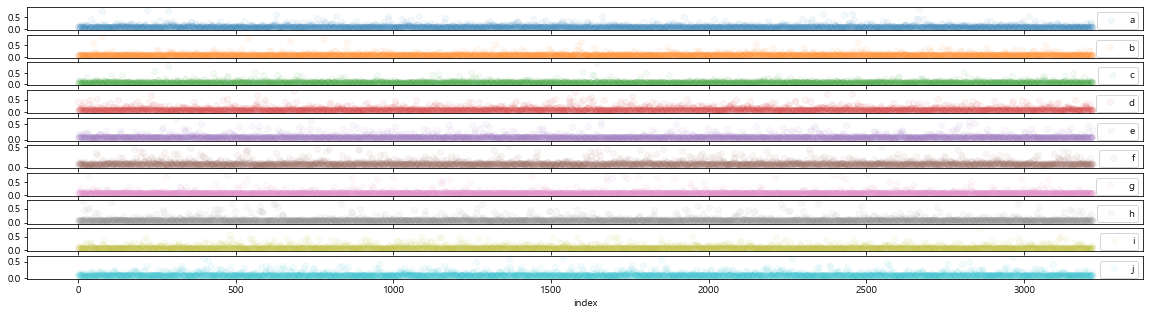

In [10]:
colnames = list (data.columns)
data.reset_index().plot(x="index", y=colnames[0:], kind = 'line', 
                        legend=True,
                        subplots = True, 
                        sharex = True, 
                        alpha=0.05,
                        figsize = (20,5),
                        ls="none", marker="o")

#plt.xlim([0, 1])      # X축의 범위: [xmin, xmax]

plt.show()

In [9]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        #print(", ".join([feature_names[i]+'('+str(topic[i])+')' for i in topic.argsort()[:-n_top_words - 1:-1]]))
        # 위 slicing에서 맨 뒤 -1은 역순을 의미, 역순으로 했을 때 처음부터 n_top_words까지
    print()

print_top_words(lda, cv.get_feature_names(), 10)

Topic #0: com, article, sandvik, apple, university, kent, science, wrote, islam, frank
Topic #1: image, graphics, file, files, ftp, software, available, program, data, use
Topic #2: com, access, posting, net, digex, article, ibm, internet, like, pat
Topic #3: article, com, don't, keith, nntp, think, host, just, posting, sgi
Topic #4: key, clipper, chip, encryption, government, com, keys, law, escrow, use
Topic #5: scsi, university, nntp, host, thanks, posting, com, know, bit, bus
Topic #6: space, nasa, gov, launch, orbit, center, earth, shuttle, satellite, research
Topic #7: drive, disk, hard, com, controller, drives, dos, problem, tape, floppy
Topic #8: key, public, mail, faq, message, pgp, information, university, group, des
Topic #9: god, people, don't, jesus, just, think, say, believe, does, know



In [11]:

data
data.plot(
    kind='scatter',
    x= data.index, 
    y=['b', 'c'], 
    backend='plotly', 
    width=500, 
    #figsize=(25,3)
)

a         b         c         d         e         f         g  \
0     0.014718  0.007004  0.007970  0.829241  0.008136  0.007594  0.020370   
1     0.162335  0.035343  0.455097  0.059365  0.047241  0.034243  0.037936   
2     0.040631  0.025993  0.022583  0.048445  0.023327  0.052796  0.025844   
3     0.268047  0.031567  0.063648  0.102170  0.035625  0.058894  0.124090   
4     0.434747  0.021806  0.025973  0.023776  0.021121  0.017714  0.022683   
...        ...       ...       ...       ...       ...       ...       ...   
3214  0.045937  0.027532  0.026616  0.019312  0.715127  0.023388  0.054297   
3215  0.027292  0.022110  0.026266  0.031721  0.018165  0.081589  0.015491   
3216  0.036017  0.042173  0.042407  0.043095  0.569081  0.034938  0.038345   
3217  0.025067  0.383977  0.085354  0.021499  0.031085  0.294315  0.018018   
3218  0.015526  0.010387  0.011452  0.466663  0.011282  0.011084  0.011847   

             h         i         j  
0     0.007411  0.006700  0.090857  
1     0.073867  0.031442  0.063132  
2     0.618113  0.092406  0.049862  
3     0.030252  0.130830  0.154876  
4     0.017909  0.017701  0.396569  
...        ...       ...       ...  
3214  0.020333  0.041396  0.026062  
3215  0.021248  0.714028  0.042089  
3216  0.034200  0.116320  0.043425  
3217  0.058213  0.049035  0.033437  
3218  0.010553  0.029824  0.421382  

[3219 rows x 10 columns]

n_components: 6, perplexity: 1052.061
n_components: 7, perplexity: 1055.910
n_components: 8, perplexity: 1027.856
n_components: 9, perplexity: 1018.301
n_components: 10, perplexity: 1024.421
n_components: 11, perplexity: 1035.376
n_components: 12, perplexity: 1031.050
n_components: 13, perplexity: 1039.640
n_components: 14, perplexity: 1038.313
n_components: 15, perplexity: 1043.554


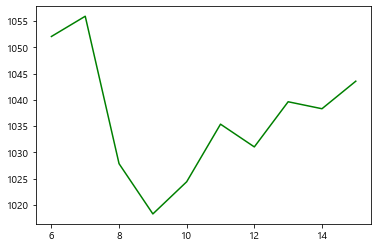

n_components with minimum perplexity: 9


In [12]:
def show_perplexity(cv, start=10, end=30, max_iter=5, topic_word_prior= 0.1, 
                    doc_topic_prior=1.0):
    iter_num = []
    per_value = []

    for i in range(start, end + 1):
        lda = LatentDirichletAllocation(n_components = i, max_iter=max_iter, 
                                        topic_word_prior= topic_word_prior, 
                                        doc_topic_prior=doc_topic_prior,
                                        learning_method='batch', n_jobs= -1,
                                        random_state=7)    
        lda.fit(cv)
        iter_num.append(i)
        pv = lda.perplexity(cv)
        per_value.append(pv)
        print(f'n_components: {i}, perplexity: {pv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.show()
    return start + per_value.index(min(per_value))

print("n_components with minimum perplexity:",
      show_perplexity(review_cv, start=6, end=15))

In [13]:
lda = LatentDirichletAllocation(n_components = 9, #추출할 topic의 수를 지정
                                max_iter=20, 
                                topic_word_prior= 0.1, 
                                doc_topic_prior=1.0,
                                learning_method='batch',
                                n_jobs= -1, 
                                random_state=7)

review_topics = lda.fit_transform(review_cv)

print_top_words(lda, cv.get_feature_names(), 10)

Topic #0: image, available, file, mail, ftp, data, information, files, graphics, software
Topic #1: gov, nasa, ___, center, posting, washington, research, distribution, host, orbit
Topic #2: com, keith, morality, caltech, sgi, article, objective, think, don't, moral
Topic #3: jesus, god, just, com, article, know, don't, people, good, john
Topic #4: people, god, don't, does, think, say, believe, way, just, evidence
Topic #5: drive, scsi, disk, card, hard, ide, controller, bus, drives, bit
Topic #6: space, access, launch, year, article, nasa, digex, moon, shuttle, henry
Topic #7: key, encryption, clipper, chip, government, com, keys, security, use, public
Topic #8: com, posting, university, nntp, host, i'm, know, article, thanks, help



# 2. Gensim을 이용한 토픽 모델링

In [11]:
# !pip install --upgrade gensim

In [15]:
newsgroups_train.data[0]

'From: livesey@solntze.wpd.sgi.com (Jon Livesey)\nSubject: Re: Moraltiy? (was Re: <Political Atheists?)\nOrganization: sgi\nLines: 63\nNNTP-Posting-Host: solntze.wpd.sgi.com\n\nIn article <1ql8ekINN635@gap.caltech.edu>, keith@cco.caltech.edu (Keith Allan Schneider) writes:\n|> livesey@solntze.wpd.sgi.com (Jon Livesey) writes:\n|> \n|> >>>>What if I act morally for no particular reason?  Then am I moral?  What\n|> >>>>if morality is instinctive, as in most animals?\n|> >>>\n|> >>>Saying that morality is instinctive in animals is an attempt to \n|> >>>assume your conclusion.\n|> >>\n|> >>Which conclusion?\n|> >\n|> >You conclusion - correct me if I err - that the behaviour which is\n|> >instinctive in animals is a "natural" moral system.\n|> \n|> See, we are disagreeing on the definition of moral here.  Earlier, you said\n|> that it must be a conscious act.  By your definition, no instinctive\n|> behavior pattern could be an act of morality.  You are trying to apply\n|> human terms to no

In [16]:
# 필요한 library들을 import
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

cachedStopWords = stopwords.words("english")

RegTok = RegexpTokenizer("[\w']{3,}") # 정규포현식으로 토크나이저를 정의
english_stops = set(stopwords.words('english')) #영어 불용어를 가져옴

def tokenizer(text):
    tokens = RegTok.tokenize(text.lower()) 
    # stopwords 제외
    words = [word for word in tokens if (word not in english_stops) and len(word) > 2]
    return words

texts = [tokenizer(news) for news in newsgroups_train.data]
len(texts)
type(texts)  # 
texts[0]

3219

list

['livesey',
 'solntze',
 'wpd',
 'sgi',
 'com',
 'jon',
 'livesey',
 'subject',
 'moraltiy',
 'political',
 'atheists',
 'organization',
 'sgi',
 'lines',
 'nntp',
 'posting',
 'host',
 'solntze',
 'wpd',
 'sgi',
 'com',
 'article',
 '1ql8ekinn635',
 'gap',
 'caltech',
 'edu',
 'keith',
 'cco',
 'caltech',
 'edu',
 'keith',
 'allan',
 'schneider',
 'writes',
 'livesey',
 'solntze',
 'wpd',
 'sgi',
 'com',
 'jon',
 'livesey',
 'writes',
 'act',
 'morally',
 'particular',
 'reason',
 'moral',
 'morality',
 'instinctive',
 'animals',
 'saying',
 'morality',
 'instinctive',
 'animals',
 'attempt',
 'assume',
 'conclusion',
 'conclusion',
 'conclusion',
 'correct',
 'err',
 'behaviour',
 'instinctive',
 'animals',
 'natural',
 'moral',
 'system',
 'see',
 'disagreeing',
 'definition',
 'moral',
 'earlier',
 'said',
 'must',
 'conscious',
 'act',
 'definition',
 'instinctive',
 'behavior',
 'pattern',
 'could',
 'act',
 'morality',
 'trying',
 'apply',
 'human',
 'terms',
 'non',
 'humans',


In [16]:
from gensim.corpora.dictionary import Dictionary

# 토큰화 결과로부터 dictionay 생성
dictionary = Dictionary(texts)
print('#Number of initial unique words in documents:', len(dictionary))

# 문서 빈도수가 너무 적거나 높은 단어를 필터링하고 특성을 단어의 빈도 순으로 선택
dictionary.filter_extremes(keep_n=2000, no_below=5, no_above=0.5)
print('#Number of unique words after removing rare and common words:', len(dictionary))

# 카운트 벡터로 변환
corpus = [dictionary.doc2bow(text) for text in texts]
print('#Number of unique tokens: %d' % len(dictionary))
print('#Number of documents: %d' % len(corpus))

#Number of initial unique words in documents: 46466
#Number of unique words after removing rare and common words: 2000
#Number of unique tokens: 2000
#Number of documents: 3219


In [17]:
from gensim.models import LdaModel

num_topics = 10
passes = 5
%time model = LdaModel(corpus=corpus, id2word=dictionary,\
                       passes=passes, num_topics=num_topics, \
                       random_state=7)

Wall time: 10.7 s


In [18]:
model.print_topics(num_words=10)

[(0,
  '0.023*"com" + 0.018*"keith" + 0.016*"caltech" + 0.013*"sgi" + 0.013*"nntp" + 0.013*"posting" + 0.013*"host" + 0.012*"would" + 0.012*"system" + 0.011*"livesey"'),
 (1,
  '0.020*"morality" + 0.018*"objective" + 0.015*"one" + 0.015*"say" + 0.014*"uiuc" + 0.012*"frank" + 0.012*"values" + 0.010*"faq" + 0.010*"article" + 0.008*"cso"'),
 (2,
  '0.026*"com" + 0.025*"access" + 0.025*"posting" + 0.023*"host" + 0.023*"nntp" + 0.017*"digex" + 0.015*"article" + 0.013*"cwru" + 0.013*"___" + 0.013*"net"'),
 (3,
  '0.021*"university" + 0.017*"posting" + 0.015*"host" + 0.015*"nntp" + 0.013*"article" + 0.010*"com" + 0.009*"know" + 0.009*"i\'m" + 0.009*"would" + 0.009*"thanks"'),
 (4,
  '0.032*"com" + 0.015*"would" + 0.011*"article" + 0.010*"one" + 0.010*"get" + 0.009*"people" + 0.009*"ibm" + 0.008*"government" + 0.007*"good" + 0.007*"i\'m"'),
 (5,
  '0.025*"key" + 0.017*"encryption" + 0.014*"clipper" + 0.014*"chip" + 0.009*"keys" + 0.009*"use" + 0.008*"security" + 0.008*"government" + 0.008*"pub

In [19]:
print("#topic distribution of the first document: ", model.get_document_topics(corpus)[0])
for i, j in enumerate(model.get_document_topics(corpus)):
    if i < 10:
        print(f'{i}번째 문서의 토픽과 그 비중은  {j}')
    else:
        pass

#topic distribution of the first document:  [(0, 0.72576934), (8, 0.2699505)]
0번째 문서의 토픽과 그 비중은  [(0, 0.72577816), (8, 0.26994175)]
1번째 문서의 토픽과 그 비중은  [(5, 0.2871588), (8, 0.35643056), (9, 0.32722855)]
2번째 문서의 토픽과 그 비중은  [(0, 0.017177526), (5, 0.087523624), (6, 0.8843548)]
3번째 문서의 토픽과 그 비중은  [(3, 0.9774903)]
4번째 문서의 토픽과 그 비중은  [(8, 0.98635966)]
5번째 문서의 토픽과 그 비중은  [(0, 0.0406194), (4, 0.05756662), (5, 0.34274298), (9, 0.5499759)]
6번째 문서의 토픽과 그 비중은  [(2, 0.3086016), (3, 0.24848235), (4, 0.429702)]
7번째 문서의 토픽과 그 비중은  [(3, 0.6119942), (7, 0.35836503)]
8번째 문서의 토픽과 그 비중은  [(0, 0.7485349), (4, 0.102236375), (8, 0.14108606)]
9번째 문서의 토픽과 그 비중은  [(2, 0.9799923)]


In [79]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.137200  0.040249       1        1  22.650738
5      0.065990  0.123620       2        1  14.528191
9      0.072133  0.092872       3        1  12.988943
7      0.138320  0.043609       4        1  11.018118
4     -0.021828  0.007495       5        1   9.294230
6      0.072783 -0.094709       6        1   9.121004
3      0.027374 -0.054949       7        1   8.493319
0     -0.040786 -0.129974       8        1   4.525002
2      0.005359 -0.091972       9        1   4.054036
1     -0.182144  0.063761      10        1   3.326419, topic_info=            Term         Freq        Total Category  logprob  loglift
538        space  1487.000000  1487.000000  Default  30.0000  30.0000
20           com  3751.000000  3751.000000  Default  29.0000  29.0000
834          key  1316.000000  1316.000000  Default  28.0000  28.0000
1551        scsi   741.000000   741.000000  Default  27.0000  27.0000
70       posting  1723.000000  1723.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
65        people    64.441534  1672.319691  Topic10  -5.1558   0.1471
789          sci    53.261833   309.499666  Topic10  -5.3463   1.6435
602   university    56.858998  1487.268025  Topic10  -5.2810   0.1392
294         time    55.764213  1187.662099  Topic10  -5.3004   0.3447
315       better    54.189534   564.525365  Topic10  -5.3290   1.0598

[592 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1359      1  0.006275      128
1359      2  0.069023      128
1359      3  0.037649      128
1359      4  0.878478      128
153       1  0.057457     1993
...     ...       ...      ...
343       8  0.022397    years
343       9  0.005599    years
343      10  0.121315    years
704       3  0.991372      zoo
705       3  0.983923  zoology

[2804 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 10, 8, 5, 7, 4, 1, 3, 2])

# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

In [20]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [21]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
df = df.loc[df.target_names.isin(['soc.religion.christian', 'rec.sport.hockey', 'talk.politics.mideast', 'rec.motorcycles']) , :]
print(df.shape)  #> (2361, 3)
df.head()

(2361, 3)


content  target  \
10  From: irwin@cmptrc.lonestar.org (Irwin Arnstei...       8   
21  From: leunggm@odin.control.utoronto.ca (Gary L...      10   
28  From: jonh@david.wheaton.edu (Jonathan Hayward...      15   
33  From: ayr1@cunixa.cc.columbia.edu (Amir Y Rose...      17   
35  From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...      10   

              target_names  
10         rec.motorcycles  
21        rec.sport.hockey  
28  soc.religion.christian  
33   talk.politics.mideast  
35        rec.sport.hockey

In [22]:
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.sys.ibm.pc.hardware',
 'sci.crypt',
 'sci.space',
 'talk.religion.misc']

In [23]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.content.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])
len(data_words)
type(data_words)

[['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', 'organization', 'computrac', 'inc', 'richardson', 'tx', 'keywords', 'ducati', 'gts', 'how', 'much', 'lines', 'have', 'line', 'on', 'ducati', 'gts', 'model', 'with', 'on', 'the', 'clock', 'runs', 'very', 'well', 'paint', 'is', 'the', 'bronze', 'brown', 'orange', 'faded', 'out', 'leaks', 'bit', 'of', 'oil', 'and', 'pops', 'out', 'of', 'st', 'with', 'hard', 'accel', 'the', 'shop', 'will', 'fix', 'trans', 'and', 'oil', 'leak', 'they', 'sold', 'the', 'bike', 'to', 'the', 'and', 'only', 'owner', 'they', 'want', 'and', 'am', 'thinking', 'more', 'like', 'any', 'opinions', 'out', 'there', 'please', 'email', 'me', 'thanks', 'it', 'would', 'be', 'nice', 'stable', 'mate', 'to', 'the', 'beemer', 'then', 'ill', 'get', 'jap', 'bike', 'and', 'call', 'myself', 'axis', 'motors', 'tuba', 'irwin', 'honk', 'therefore', 'am', 'computrac', 'r

2361

list

In [24]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_words]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.020*"the" + 0.010*"team" + 0.009*"hockey" + 0.008*"in" + 0.008*"for" + '
  '0.007*"organization" + 0.007*"lines" + 0.007*"on" + 0.007*"from" + '
  '0.007*"subject"'),
 (1,
  '0.062*"the" + 0.036*"to" + 0.032*"of" + 0.024*"and" + 0.022*"in" + '
  '0.021*"is" + 0.021*"that" + 0.014*"it" + 0.014*"you" + 0.011*"not"'),
 (2,
  '0.068*"the" + 0.046*"of" + 0.024*"in" + 0.023*"and" + 0.011*"to" + '
  '0.010*"were" + 0.009*"by" + 0.008*"turkish" + 0.006*"their" + '
  '0.006*"turks"'),
 (3,
  '0.017*"israel" + 0.012*"israeli" + 0.012*"from" + 0.008*"subject" + '
  '0.008*"posting" + 0.008*"article" + 0.007*"organization" + 0.007*"nntp" + '
  '0.007*"host" + 0.007*"lines"')]


In [87]:
data_ready = data_words
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0               1              0.5247   
1            1               1              0.5607   
2            2               1              0.9642   
3            3               1              0.5417   
4            4               1              0.6610   
5            5               1              0.8281   
6            6               1              0.6204   
7            7               1              0.6027   
8            8               1              0.9896   
9            9               2              0.5255   

                                            Keywords  \
0       the, to, of, and, in, is, that, it, you, not   
1       the, to, of, and, in, is, that, it, you, not   
2       the, to, of, and, in, is, that, it, you, not   
3       the, to, of, and, in, is, that, it, you, not   
4       the, to, of, and, in, is, that, it, you, not   
5       the, to, of, and, in, is, that, it, you, not   
6       the, to, of, and, in, is, that, it, you, not   
7       the, to, of, and, in, is, that, it, you, not   
8       the, to, of, and, in, is, that, it, you, not   
9  the, of, in, and, to, were, by, turkish, their...   

                                                Text  
0  [from, irwin, arnstein, subject, re, recommend...  
1  [from, gary, leung, subject, re, nhl, team, ca...  
2  [from, jonathan, hayward, subject, re, panthei...  
3  [from, amir, rosenblatt, subject, re, israeli,...  
4  [from, deepak, chhabra, subject, re, goalie, m...  
5  [from, joe, ehrlich, subject, re, bmw, moa, me...  
6  [from, chris, behanna, subject, re, should, li...  
7  [from, speedy, mercer, subject, re, looking, f...  
8  [from, darius_lecointe, subject, re, sabbath, ...  
9  [from, serdar, argic, subject, day, and, night...

In [88]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

Topic_Num  Topic_Perc_Contrib  \
0          0              0.9989   
1          1              0.9989   
2          2              0.9320   
3          3              0.7976   

                                                                            Keywords  \
0                 the, team, hockey, in, for, organization, lines, on, from, subject   
1                                       the, to, of, and, in, is, that, it, you, not   
2                              the, of, in, and, to, were, by, turkish, their, turks   
3  israel, israeli, from, subject, posting, article, organization, nntp, host, lines   

                                                                                   Representative Text  
0  [subject, nhl, summary, parse, results, for, games, played, sat, april, from, cook, charlie, org...  
1  [from, subject, re, the, arrogance, of, christians, organization, monash, university, melbourne,...  
2  [from, serdar, argic, subject, armenian, genocide, of, the, muslim, people, in, and, article, zu...  
3  [from, center, for, policy, research, subject, poem, by, erich, fried, nf, id, cdp, nf, from, cd...

<Figure size 1920x1120 with 0 Axes>

(array([ 18.,  44.,  33.,  51.,  72.,  65.,  89., 106.,  97.,  89.,  88.,
        102., 104.,  90.,  75.,  75.,  56.,  60.,  66.,  51.,  37.,  54.,
         43.,  27.,  40.,  41.,  30.,  37.,  22.,  23.,  19.,  23.,  20.,
         10.,  14.,  23.,  22.,  22.,  13.,  16.,  12.,  18.,   8.,   9.,
         18.,   5.,   9.,  11.,  15.,  11.,  17.,   8.,   3.,   5.,   8.,
          8.,   7.,   5.,   2.,   4.,   2.,   5.,   6.,   6.,   4.,  12.,
          6.,   3.,   2.,   3.,   4.,   8.,   5.,   6.,   3.,   1.,   5.,
          5.,   3.,   0.,   0.,   7.,   1.,   3.,   3.,   1.,   2.,   0.,
          1.,   0.,   2.,   3.,   1.,   2.,   1.,   2.,   4.,   2.,   3.,
          2.,   1.,   1.,   2.,   1.,   0.,   0.,   1.,   3.,   0.,   3.,
          0.,   2.,   2.,   2.,   0.,   1.,   2.,   1.,   0.,   0.,   3.,
          1.,   0.,   1.,   2.,   1.,   2.,   0.,   0.,   0.,   0.,   2.,
          1.,   1.,   3.,   1.,   1.,   0.,   2.,   0.,   0.,   0.,   0.,
          0.,   1.,   1.,   0.,   0., 

Text(750, 100, 'Mean   : 308')

Text(750, 90, 'Median : 183')

Text(750, 80, 'Stdev   : 520')

Text(750, 70, '1%ile    : 29')

Text(750, 60, '99%ile  : 1840')

[(0.0, 1000.0),
 Text(0, 0.5, 'Number of Documents'),
 Text(0.5, 0, 'Document Word Count')]

([<matplotlib.axis.XTick at 0x19865a61310>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 1.0, 'Distribution of Document Word Counts')

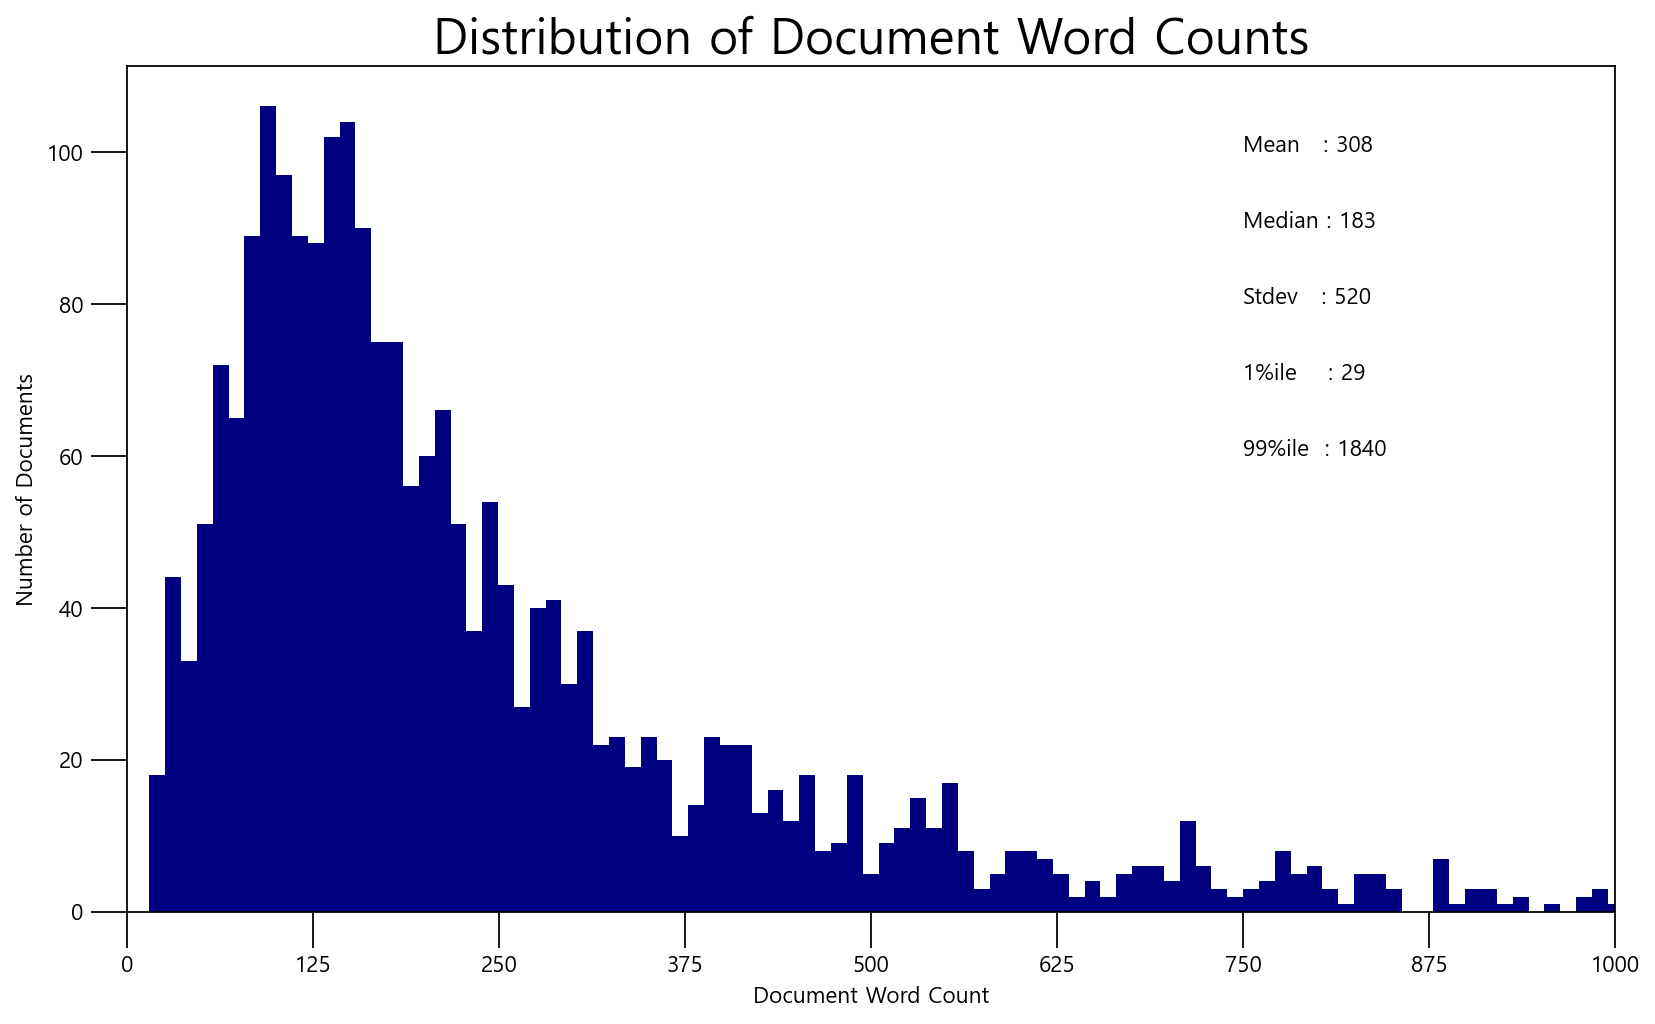

In [90]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(12,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()


(array([ 8., 21., 10., 14., 15., 17., 20., 10., 14., 12., 15.,  5., 11.,
         9.,  6.,  5.,  4.,  3.,  3.,  5.,  2.,  2.,  2.,  1.,  0.,  5.,
         0.,  2.,  1.,  3.,  2.,  2.,  1.,  1.,  0.,  0.,  1.,  2.,  2.,
         0.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,
         0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,
         0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

<AxesSubplot:label='457f5001-49e6-4206-ab22-a392288704f4', ylabel='Density'>

[(0.0, 1000.0), Text(0.5, 0, 'Document Word Count')]

Text(0, 0.5, 'Number of Documents')

Text(0.5, 1.0, 'Topic: 0')

(array([12., 23., 24., 33., 45., 48., 80., 92., 73., 70., 87., 94., 82.,
        82., 62., 60., 61., 48., 58., 40., 43., 53., 32., 29., 32., 29.,
        29., 35., 16., 23., 19., 17., 16., 10., 15., 20., 20., 15., 12.,
        12., 15., 13.,  6., 15., 11.,  3., 11., 11., 10., 17.,  9.,  5.,
         3.,  7.,  6.,  6.,  7.,  4.,  2.,  2.,  4.,  1.,  6.,  5.,  2.,
        11.,  2.,  5.,  2.,  1.,  5., 10.,  2.,  3.,  2.,  3.,  2.,  4.,
         1.,  0.,  0.,  5.,  1.,  2.,  2.,  2.,  1.,  1.,  0.,  1.,  2.,
         2.,  1.,  2.,  1.,  3.,  3.,  2.,  2.,  3.,  0.,  1.,  3.,  0.,
         0.,  0.,  2.,  0.,  0.,  3.,  2.,  0.,  2.,  0.,  0.,  0.,  0.,
         1.,  0.,  1.,  1.,  1.,  1.,  0.,  2.,  1.,  2.,  0.,  0.,  0.,
         0.,  1.,  1.,  2.,  1.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  3.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.,  2.,  0.,  1.,  1.,  0.,  0.,  0.

<AxesSubplot:label='fa86dcfb-be82-47b6-af33-b05f593284da', ylabel='Density'>

[(0.0, 1000.0), Text(0.5, 0, 'Document Word Count')]

Text(0, 0.5, 'Number of Documents')

Text(0.5, 1.0, 'Topic: 1')

(array([1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 0., 1., 0., 3., 0., 0., 0., 2., 0., 0., 1., 0., 2.,
        0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 3., 1.,
        0., 0., 0., 1., 2., 2., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
        0., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        2., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 

<AxesSubplot:label='113ee7e4-8e9f-47ab-82e4-4c658c4486a5', ylabel='Density'>

[(0.0, 1000.0), Text(0.5, 0, 'Document Word Count')]

Text(0, 0.5, 'Number of Documents')

Text(0.5, 1.0, 'Topic: 2')

(array([1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 

<AxesSubplot:label='2b262a41-05ba-479e-8258-c779c2ff2809', ylabel='Density'>

[(0.0, 1000.0), Text(0.5, 0, 'Document Word Count')]

Text(0, 0.5, 'Number of Documents')

Text(0.5, 1.0, 'Topic: 3')

([<matplotlib.axis.XTick at 0x1986f098520>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 0.98, 'Distribution of Document Word Counts by Dominant Topic')

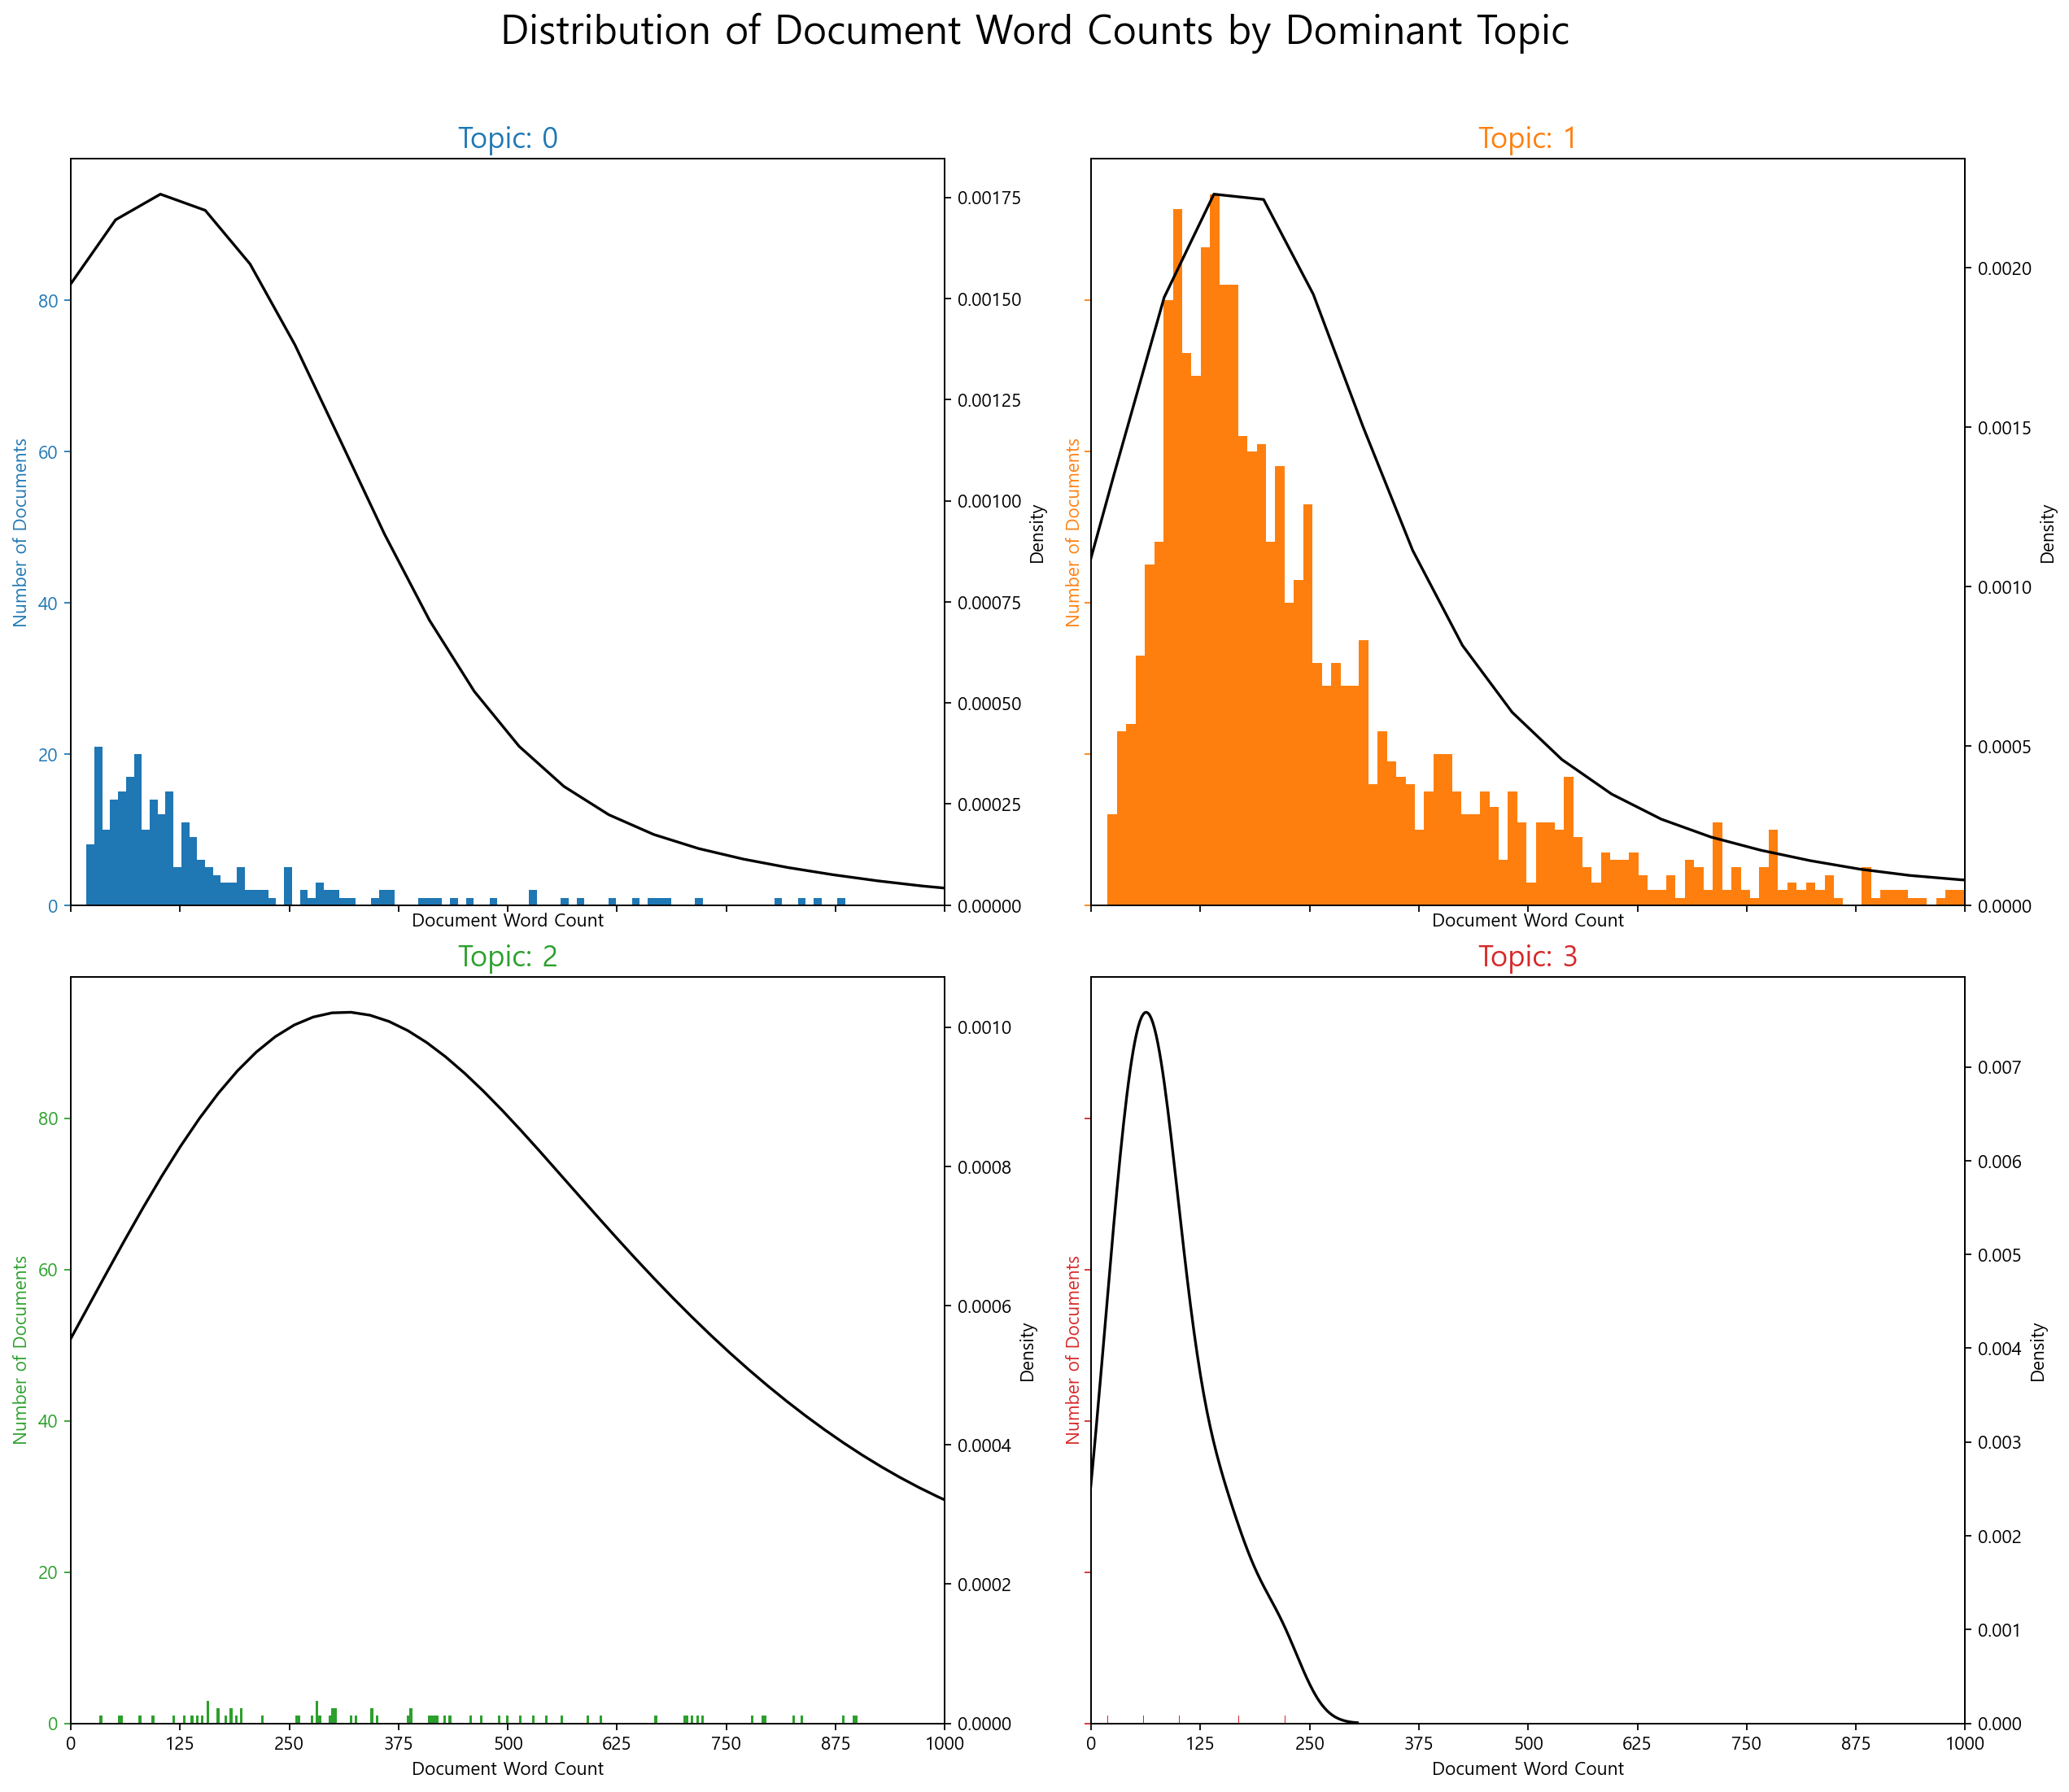

In [92]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

<AxesSubplot:>

Text(0.5, 1.0, 'Topic 0')

(-0.5, 2499.5, 1799.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Topic 1')

(-0.5, 2499.5, 1799.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Topic 2')

(-0.5, 2499.5, 1799.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Topic 3')

(-0.5, 2499.5, 1799.5, -0.5)

(-0.5, 2499.5, 1799.5, -0.5)

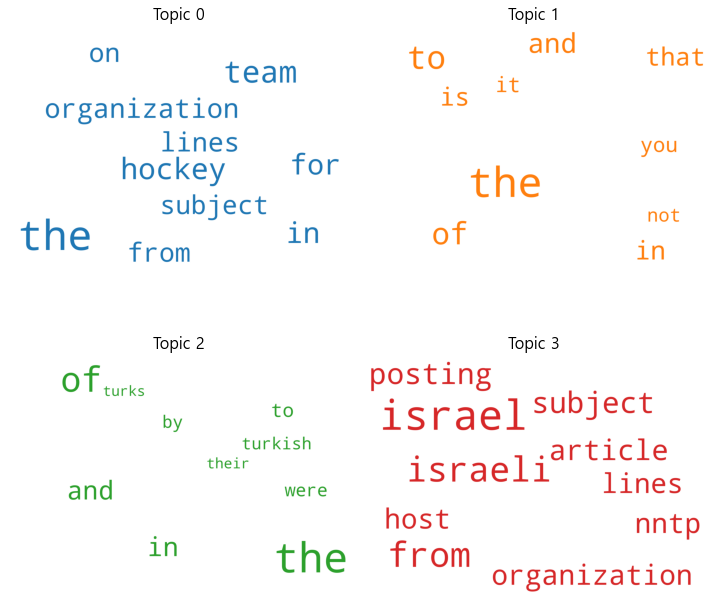

In [93]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 3500.0)

Text(0.5, 1.0, 'Topic: 0')

[Text(0, 0, 'the'),
 Text(1, 0, 'team'),
 Text(2, 0, 'hockey'),
 Text(3, 0, 'in'),
 Text(4, 0, 'for'),
 Text(5, 0, 'organization'),
 Text(6, 0, 'lines'),
 Text(7, 0, 'on'),
 Text(8, 0, 'from'),
 Text(9, 0, 'subject')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 3500.0)

Text(0.5, 1.0, 'Topic: 1')

[Text(0, 0, 'the'),
 Text(1, 0, 'to'),
 Text(2, 0, 'of'),
 Text(3, 0, 'and'),
 Text(4, 0, 'in'),
 Text(5, 0, 'is'),
 Text(6, 0, 'that'),
 Text(7, 0, 'it'),
 Text(8, 0, 'you'),
 Text(9, 0, 'not')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 3500.0)

Text(0.5, 1.0, 'Topic: 2')

[Text(0, 0, 'the'),
 Text(1, 0, 'of'),
 Text(2, 0, 'in'),
 Text(3, 0, 'and'),
 Text(4, 0, 'to'),
 Text(5, 0, 'were'),
 Text(6, 0, 'by'),
 Text(7, 0, 'turkish'),
 Text(8, 0, 'their'),
 Text(9, 0, 'turks')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 3500.0)

Text(0.5, 1.0, 'Topic: 3')

[Text(0, 0, 'israel'),
 Text(1, 0, 'israeli'),
 Text(2, 0, 'from'),
 Text(3, 0, 'subject'),
 Text(4, 0, 'posting'),
 Text(5, 0, 'article'),
 Text(6, 0, 'organization'),
 Text(7, 0, 'nntp'),
 Text(8, 0, 'host'),
 Text(9, 0, 'lines')]

Text(0.5, 1.05, 'Word Count and Importance of Topic Keywords')

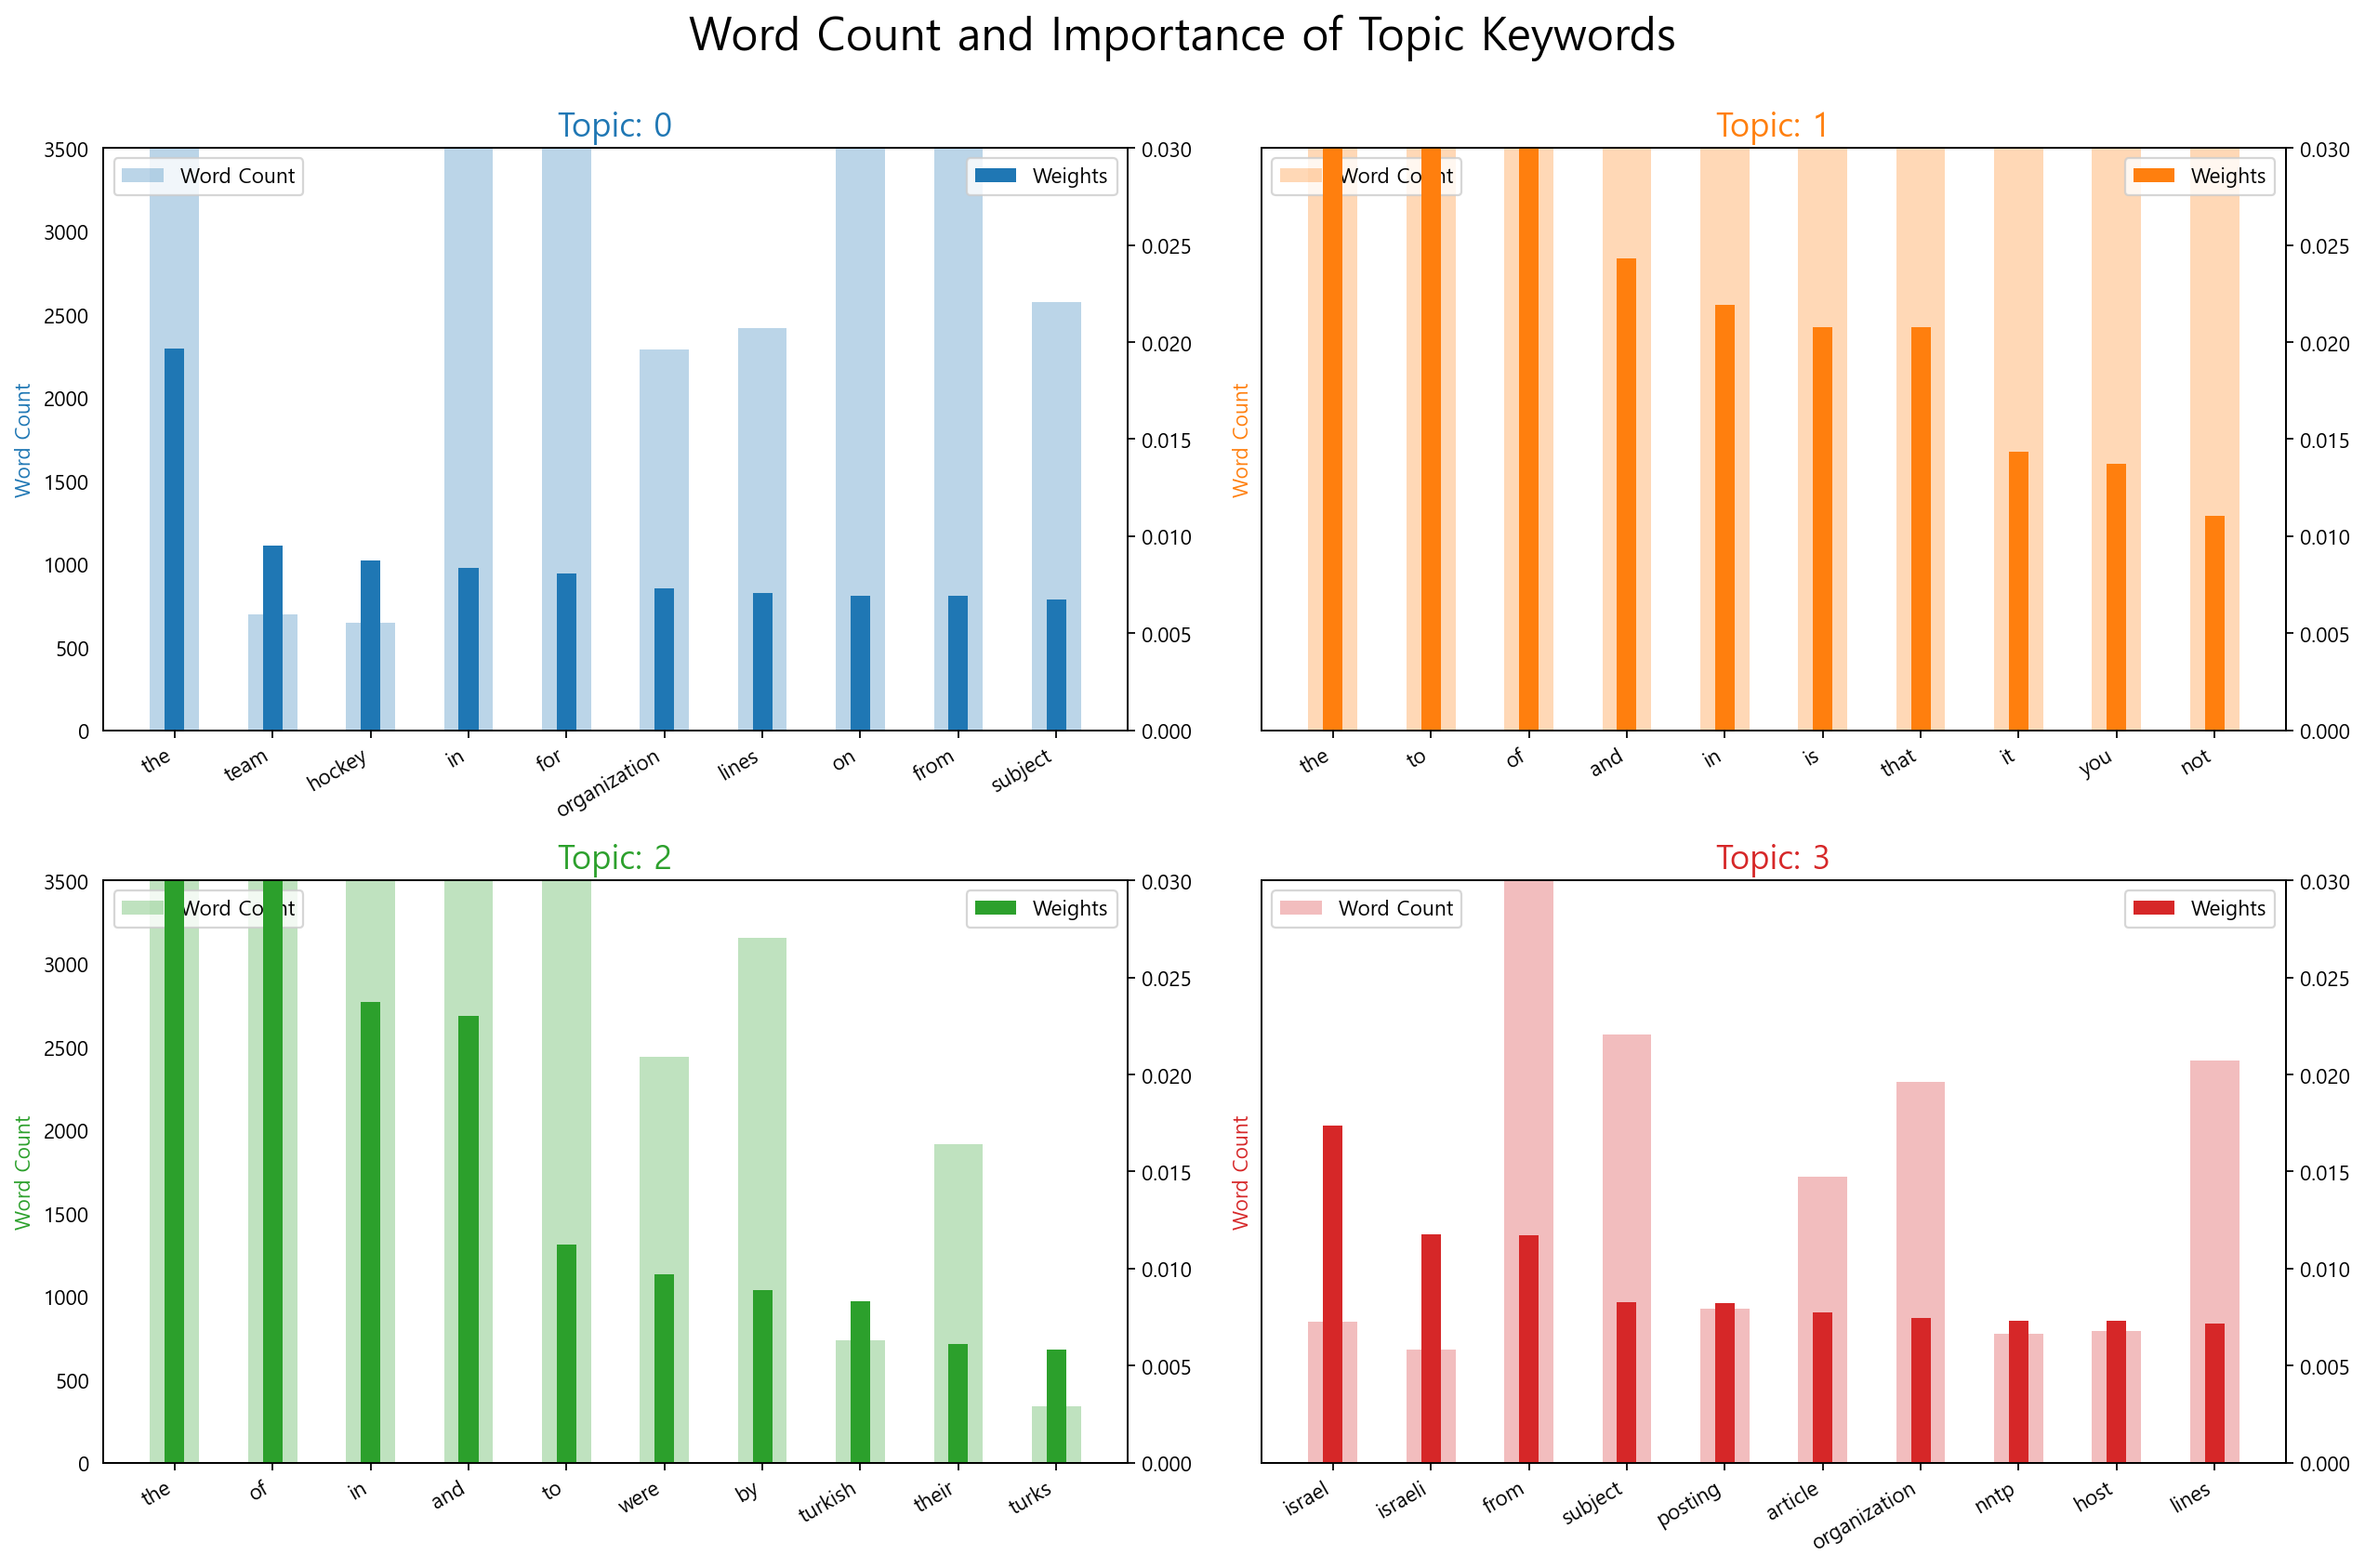

In [94]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

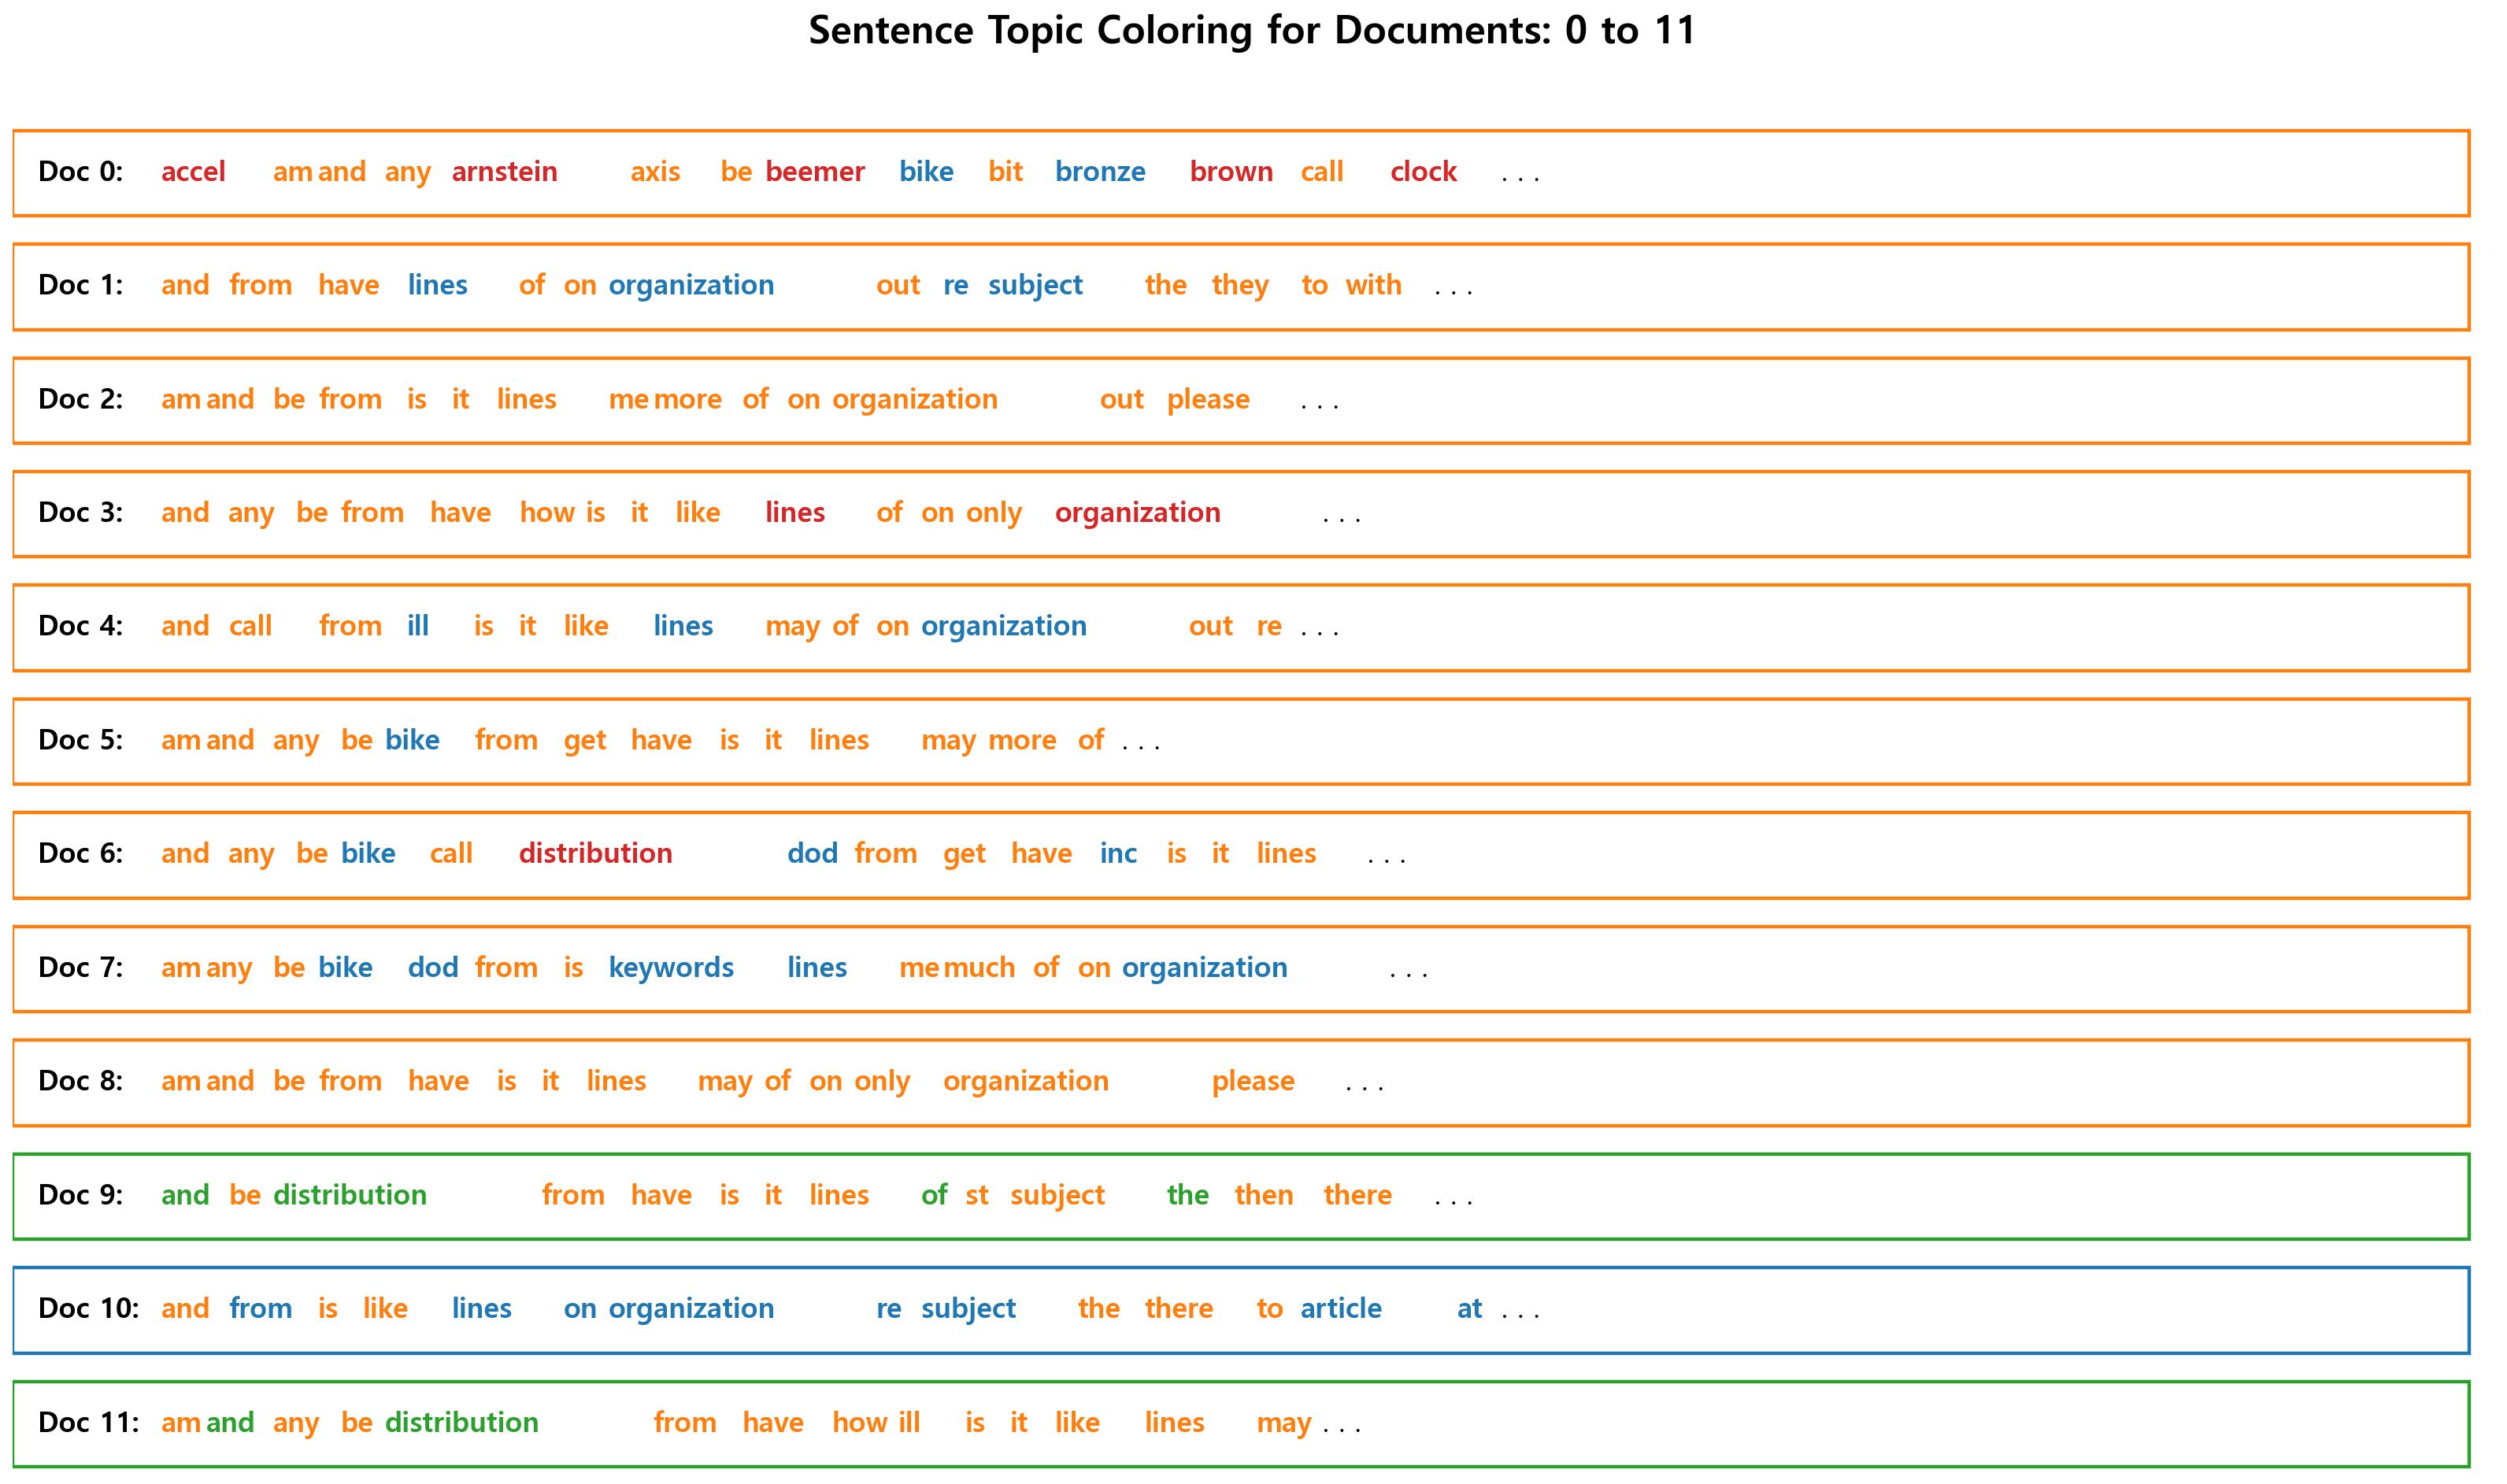

In [95]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

In [96]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

In [97]:
df_top3words

topic_id                      words
0         0      the, \nteam, \nhockey
1         1            the, \nto, \nof
2         2            the, \nof, \nin
3         3  israel, \nisraeli, \nfrom

<BarContainer object of 4 artists>

Text(0.5, 1.0, 'Number of Documents by Dominant Topic')

Text(0, 0.5, 'Number of Documents')

(0.0, 1000.0)

<BarContainer object of 4 artists>

Text(0.5, 1.0, 'Number of Documents by Topic Weightage')

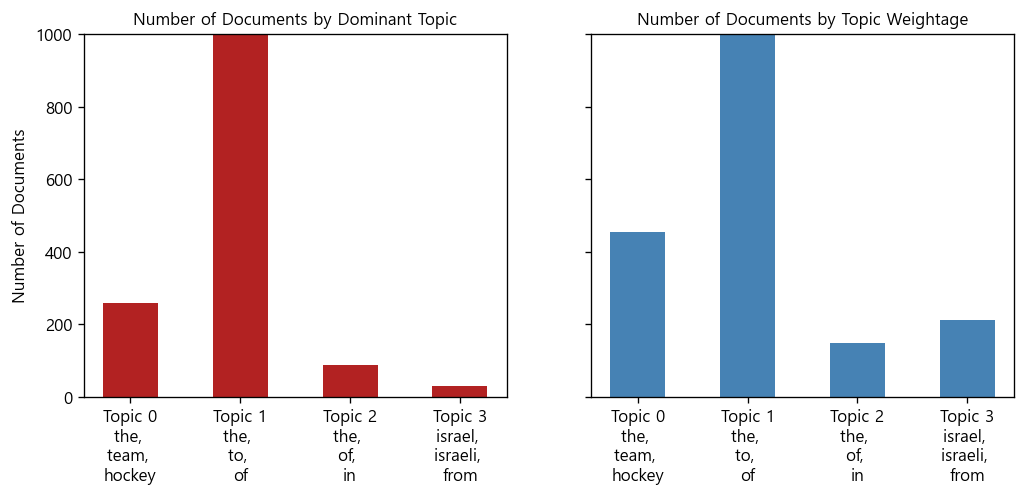

In [98]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()


In [99]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2356 samples in 0.011s...
[t-SNE] Computed neighbors for 2356 samples in 0.035s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2356
[t-SNE] Computed conditional probabilities for sample 2000 / 2356
[t-SNE] Computed conditional probabilities for sample 2356 / 2356
[t-SNE] Mean sigma: 0.004288
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.448734
[t-SNE] KL divergence after 1000 iterations: 0.524561


Loading BokehJS ...

GlyphRenderer(id='1040', ...)

In [100]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.252238 -0.029702       1        1  69.181273
0      0.124544 -0.248130       2        1  13.209758
2     -0.119509  0.123448       3        1  10.704197
3      0.247202  0.154385       4        1   6.904773, topic_info=    Term          Freq         Total Category  logprob  loglift
76   the  38291.000000  38291.000000  Default  30.0000  30.0000
52    of  19742.000000  19742.000000  Default  29.0000  29.0000
2    and  14388.000000  14388.000000  Default  28.0000  28.0000
128   in  13712.000000  13712.000000  Default  27.0000  27.0000
34    is  10450.000000  10450.000000  Default  26.0000  26.0000
..   ...           ...           ...      ...      ...      ...
274   my    294.721220   2691.041965   Topic4  -5.1370   0.4613
387  edu    199.424710    516.141033   Topic4  -5.5276   1.7220
118  for    270.852450   6132.627276   Topic4  -5.2214  -0.4468
54    on    191.981674   4546.258577   Topic4  -5.5656  -0.4917
461   or    177.032781   3118.949460   Topic4  -5.6467  -0.1960

[260 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
763        1  0.999375  about
923        1  0.474287  above
923        4  0.525716  above
183        1  0.969340    all
183        2  0.002700    all
...      ...       ...    ...
11785      3  0.995086     ww
600        2  0.792017   year
600        3  0.206923   year
338        1  0.999842    you
339        1  0.999388   your

[330 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 4])

# https://techblog-history-younghunjo1.tistory.com/112